In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
from importlib import reload

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer as Imputer
from sklearn.metrics import mean_squared_log_error

from sklearn.linear_model import LinearRegression

from _lib.preprocess import preprocess_missing as prep
from _lib.preprocess import get_instruction as info
from _lib.preprocess_test import preprocess_missing as prep_test
from _lib.create_output import output

df = pd.read_csv("_database/Input/train.csv", index_col = 0)

df = prep(df)
df = df.drop([1299, 935, 186, 347, 1231, 1183, 692, 955])
X_data = df.drop("SalePrice", axis = 1)
y = df["SalePrice"]




In [4]:
# Function to generate polynomial features of numerical variables
def gen_poly(data, degree):
    '''
    Input : Vector or matrix 
    
    Return matrix of polynomial for each polynomial degree from 1 to degree calculated on each column
    '''
    
    result = np.concatenate([np.power(data, d) for d in np.arange(1, degree + 1)], axis = 1)
    return result

df_type = pd.DataFrame({"Columns" : X_data.columns, "Type" : [str(X_data[col].dtype) for col in X_data.columns]})
num_columns = df_type.loc[(df_type["Type"] == "int64") | (df_type["Type"] == "float64")]["Columns"]
cat_columns = df_type.loc[(df_type["Type"] == "category")]["Columns"]
bool_columns = df_type.loc[df_type["Type"] == "bool"]["Columns"]

# Categories in categorical features
list_categories = [np.array(info(col)) for col in cat_columns.values]
list_categories[14] = np.arange(1, 11)
list_categories[15] = np.arange(1, 11)


# Polynomial degree
poly_degree = 1

get_numerical = FunctionTransformer(lambda x : x[num_columns.values].values, validate = False)

get_category = FunctionTransformer(lambda x : x[cat_columns.values], validate = False)

get_bool = FunctionTransformer(lambda x : x[bool_columns.values].values, validate = False)

generate_poly = FunctionTransformer(lambda x : gen_poly(x, poly_degree), validate = False)

pipeline_num_prep = Pipeline([('selector', get_numerical),
                              ('poly', generate_poly)])

pipeline_cat_prep = Pipeline([('selector', get_category),
                              ('Dummy', OneHotEncoder(drop = 'first', sparse = False,
                                                     categories = list_categories))])

transformers = [ ('Numerical', pipeline_num_prep), ('Categorical', pipeline_cat_prep), ('Bool', get_bool) ]

preprocess_union = FeatureUnion(transformer_list = transformers)

pl = Pipeline([
    ('union', preprocess_union)

])

In [5]:
X = pl.fit_transform(X_data)

In [6]:
y = np.log(y)

Split the data 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

In [ ]:
ml = LinearRegression()

In [ ]:
ml.fit(X_train, y_train)

In [ ]:
y_pred = ml.predict(X_test)

In [ ]:
msle = (np.sum((np.log(y_pred + 1) - np.log(y_test + 1))**2))/(len(y_pred))

In [ ]:
print(msle)

In [ ]:
mean_squared_error(y_test, y_pred)

In [ ]:
mean_squared_log_error(y_test[y_pred > 0], y_pred[y_pred > 0])

## Using poly degree > 1

In [7]:
def poly_reg_pipeline(poly_degree):

    get_numerical = FunctionTransformer(lambda x : x[num_columns.values].values, validate = False)

    get_category = FunctionTransformer(lambda x : x[cat_columns.values], validate = False)

    get_bool = FunctionTransformer(lambda x : x[bool_columns.values].values, validate = False)

    generate_poly = FunctionTransformer(lambda x : gen_poly(x, poly_degree), validate = False)

    pipeline_num_prep = Pipeline([('selector', get_numerical),
                                  ('poly', generate_poly)])

    pipeline_cat_prep = Pipeline([('selector', get_category),
                                  ('Dummy', OneHotEncoder(drop = 'first', sparse = False,
                                                         categories = list_categories))])

    transformers = [ ('Numerical', pipeline_num_prep), ('Categorical', pipeline_cat_prep), ('Bool', get_bool) ]

    preprocess_union = FeatureUnion(transformer_list = transformers)

    pl = Pipeline([
        ('union', preprocess_union)

    ])
    
    return pl

In [8]:
n = 20
seed = 40
msle_list = []
for i in range(1, n):
    pl = poly_reg_pipeline(i)
    X = pl.fit_transform(X_data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = seed)
    ml = LinearRegression()
    ml.fit(X_train, y_train)
    
    y_pred = ml.predict(X_test)
    msle = mean_squared_error(y_test, y_pred)
    msle_list.append(msle)
    
    print("The MSLE for poly degree {} is : {}".format(i, msle))

The MSLE for poly degree 1 is : 0.03174888990982646
The MSLE for poly degree 2 is : 0.030137273133910288
The MSLE for poly degree 3 is : 0.018733543486631435
The MSLE for poly degree 4 is : 0.04562245344747324
The MSLE for poly degree 5 is : 0.3754989492206245
The MSLE for poly degree 6 is : 0.05204131494972141
The MSLE for poly degree 7 is : 0.09416180384217471
The MSLE for poly degree 8 is : 0.11045026957237022
The MSLE for poly degree 9 is : 0.16775471711148626
The MSLE for poly degree 10 is : 0.16860333494734342
The MSLE for poly degree 11 is : 0.16867632739755062
The MSLE for poly degree 12 is : 0.16865125895659555
The MSLE for poly degree 13 is : 0.168654489316241
The MSLE for poly degree 14 is : 0.16866349246203027
The MSLE for poly degree 15 is : 0.16866758769874055
The MSLE for poly degree 16 is : 0.1686438021696957
The MSLE for poly degree 17 is : 0.1686380469359363
The MSLE for poly degree 18 is : 0.1686858845783755
The MSLE for poly degree 19 is : 0.16865497757661657


Next we want to compare them using standard scaler

## Ridge

In [69]:
from sklearn.linear_model import Ridge

In [70]:
pl = poly_reg_pipeline(3)
X = pl.fit_transform(X_data)
y1 = df["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 40)

In [71]:
alpha_list = np.logspace(-3, 1, 50)

In [72]:
mse = np.zeros(len(alpha_list))
for i in np.arange(len(alpha_list)):
    ml = Ridge(alpha = alpha_list[i])
    ml.fit(X_train, y_train)
    
    y_pred = ml.predict(X_test)
    
    mse[i] = mean_squared_error(y_test, y_pred)
    

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.77538e-36): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.54181e-36): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.46075e-36): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.56131e-36): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.87772e-36): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148:

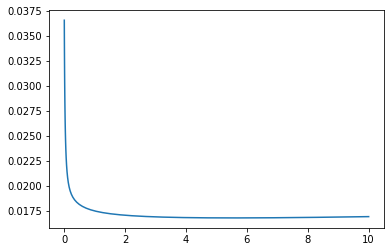

In [73]:
fig, ax = plt.subplots()
ax.plot(alpha_list, mse)

In [74]:
alpha_list1 = np.logspace(-3, 2, 50)
alpha_list2 = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000])
alpha_list = np.concatenate((alpha_list1, alpha_list2))

In [75]:
ml = Ridge()

In [76]:
params = {'alpha' : alpha_list}

In [77]:
cv = GridSearchCV(ml, param_grid = params, cv = 10)

In [78]:
cv.fit(X_train, y_train)

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.2188e-36): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.33706e-36): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.83298e-36): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.76704e-36): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76996e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: 

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.17539e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.47898e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.45231e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.46077e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.47631e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.01656e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.42632e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.34469e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.18237e-34): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.65526e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00843e-34): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.98164e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.75431e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00346e-34): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.35216e-34): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.03571e-33): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.60545e-34): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.82367e-34): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.82397e-34): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74544e-34): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.42697e-33): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.74206e-33): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.39752e-33): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.7848e-33): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.5371e-33): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: L

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.54884e-33): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.61437e-33): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.5362e-33): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.62938e-33): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.6727e-33): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: L

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.28708e-32): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.4679e-32): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.13827e-31): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.59065e-32): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.26478e-32): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: 

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.9545e-32): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.50378e-32): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.55595e-32): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.68204e-32): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.81459e-32): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: 

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.9216e-31): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.96851e-31): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.9415e-31): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.94296e-31): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.95438e-31): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: L

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46827e-34): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.79334e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.40041e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.34679e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.32551e-35): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.57699e-33): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.52007e-33): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.81226e-33): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.76067e-33): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.91985e-32): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.07944e-30): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.07654e-30): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.08373e-30): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.0521e-30): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.48999e-30): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: 

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-03, 1.26485522e-03, 1.59985872e-03, 2.02358965e-03,
       2.55954792e-03, 3.23745754e-03, 4.09491506e-03, 5.17947468e-03,
       6.5512855...
       3.08884360e+01, 3.90693994e+01, 4.94171336e+01, 6.25055193e+01,
       7.90604321e+01, 1.00000000e+02, 0.00000000e+00, 1.00000000e-03,
       3.00000000e-03, 1.00000000e-02, 3.00000000e-02, 1.00000000e-01,
       3.00000000e-01, 1.00000000e+00, 3.00000000e+00, 1.00000000e+01,
       3.00000000e+01, 1.00000000e+02, 3.00000000e+02, 1.00000000e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [79]:
cv.best_params_

{'alpha': 19.306977288832496}

In [80]:
ml = cv.best_estimator_

In [81]:
y_pred = ml.predict(X_test)

In [82]:
mean_squared_error(y_test, y_pred)

0.017457520794054552

#### Using Bootstrap

In [99]:
def bootstrap_ml(x, y, ml, size = 1):
    inds = np.arange(x.shape[0])
    bs_rep = np.empty(size)
    
    for i in range(size):
        
        bs_inds = np.random.choice(inds, size = len(inds))
        x_bs = x[bs_inds]
        y_bs = y.values.reshape(-1,1)[bs_inds]
        ml.fit(x_bs, y_bs)
        
        y_bs_pred = ml.predict(X_test)
        
        bs_rep[i] = mean_squared_error(y_test, y_bs_pred)
        
    return bs_rep

In [100]:
bss = bootstrap_ml(X_train, y_train, ml, size = 100)

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.51579e-30): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.78249e-32): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.34672e-31): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.43797e-31): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.77951e-32): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.30103e-32): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.23967e-32): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.53573e-31): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.96097e-31): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.75899e-32): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148:

(array([1., 0., 0., 1., 0., 2., 1., 3., 0., 2., 1., 0., 0., 0., 1., 1., 2.,
        1., 2., 0., 2., 1., 0., 1., 1., 0., 0., 0., 1., 1.]),
 array([0.01804065, 0.01810152, 0.01816238, 0.01822325, 0.01828412,
        0.01834498, 0.01840585, 0.01846672, 0.01852759, 0.01858845,
        0.01864932, 0.01871019, 0.01877105, 0.01883192, 0.01889279,
        0.01895365, 0.01901452, 0.01907539, 0.01913626, 0.01919712,
        0.01925799, 0.01931886, 0.01937972, 0.01944059, 0.01950146,
        0.01956232, 0.01962319, 0.01968406, 0.01974493, 0.01980579,
        0.01986666]),
 <a list of 30 Patch objects>)

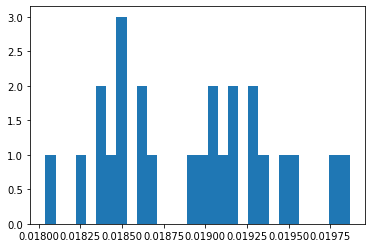

In [109]:
plt.hist(bss[bss < 0.02], bins = 30)

## another polynomial degree

In [23]:
ml = Ridge()

In [41]:
pl = poly_reg_pipeline(5)
X = pl.fit_transform(X_data)
y1 = df["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 40)

In [42]:
cv = GridSearchCV(ml, param_grid = params, cv = 10)

In [43]:
cv.fit(X_train, y_train)

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.273821160370712, tolerance: 0.01385117894641486
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.1796348116949344, tolerance: 0.013640558329594783
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.941044635257983, tolerance: 0.014051091158597507
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.384184542951822, tolerance: 0.013640558329594783
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.117103977021748, tolerance: 0.014051091158597507
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.509175064071426, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.204434740995454, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.914439763007308, tolerance: 0.01373294289391829
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.030530715444014, tolerance: 0.01372146935407299
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.439190600527382, tolerance: 0.01372146935407299
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.9971374137284394, tolerance: 0.013471849183271637
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.144944552924919, tolerance: 0.014069400686645419
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.331483676712333, tolerance: 0.014069400686645419
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.58280606819436, tolerance: 0.013702265371069703
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.45532305139856, tolerance: 0.014092013092249306
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.584254866283832, tolerance: 0.014092013092249306
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.748327238291132, tolerance: 0.01385117894641486
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.95410416395561, tolerance: 0.013640558329594783
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.918104858563991, tolerance: 0.01385117894641486
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.100362577463962, tolerance: 0.013640558329594783
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.673629302072683, tolerance: 0.014051091158597507
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.785257865342468, tolerance: 0.014051091158597507
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.27737488627492, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.87996299176899, tolerance: 0.01373294289391829
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.433373889185882, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.02179421672496, tolerance: 0.01373294289391829
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.324811573244794, tolerance: 0.01372146935407299
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.113475806133376, tolerance: 0.01373294289391829
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.42179267667718, tolerance: 0.01372146935407299
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.931187170318713, tolerance: 0.013471849183271637
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.929690146160713, tolerance: 0.013471849183271637
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.15255618452961, tolerance: 0.014069400686645419
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.340324291971816, tolerance: 0.013702265371069703
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.25532645069052, tolerance: 0.014092013092249306
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.362330450010546, tolerance: 0.01385117894641486
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.58303597490873, tolerance: 0.013640558329594783
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.630885841513312, tolerance: 0.013640558329594783
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.152198257070124, tolerance: 0.014051091158597507
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.632386839867198, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.223222221967239, tolerance: 0.014051091158597507
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.718362395081051, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.350657287709685, tolerance: 0.01373294289391829
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.80078112932446, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.410332909837608, tolerance: 0.01373294289391829
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.69620929978646, tolerance: 0.01372146935407299
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.2

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.466646344537104, tolerance: 0.01373294289391829
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.760580927431556, tolerance: 0.01372146935407299
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.282388893295423, tolerance: 0.013471849183271637
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0463623836962963, tolerance: 0.014051091158597507
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.341108517620999, tolerance: 0.013759672095818362
  positive)
C:\Anaco

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.970782748290699, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.683395793048143, tolerance: 0.01373294289391829
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.787843706168905, tolerance: 0.01372146935407299
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.747136719668173, tolerance: 0.01373294289391829
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.006370593829688, tolerance: 0.01372146935407299
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.504667330919078, tolerance: 0.013471849183271637
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.474713626414736, tolerance: 0.01372146935407299
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.001881339141878, tolerance: 0.013471849183271637
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.192680708336903, tolerance: 0.014069400686645419
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.32083600439257, tolerance: 0.013471849183271637
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.528766013796172, tolerance: 0.014069400686645419
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.654416041287211, tolerance: 0.013702265371069703
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=0.001, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-03, 1.26485522e-03, 1.59985872e-03, 2.02358965e-03,
       2.55954792e-...
       3.08884360e+01, 3.90693994e+01, 4.94171336e+01, 6.25055193e+01,
       7.90604321e+01, 1.00000000e+02, 0.00000000e+00, 1.00000000e-03,
       3.00000000e-03, 1.00000000e-02, 3.00000000e-02, 1.00000000e-01,
       3.00000000e-01, 1.00000000e+00, 3.00000000e+00, 1.00000000e+01,
       3.00000000e+01, 1.00000000e+02, 3.00000000e+02, 1.00000000e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [44]:
ridge_param = cv.best_params_

In [45]:
ml = cv.best_estimator_

In [46]:
y_pred = ml.predict(X_test)
y_pred_train = ml.predict(X_train)

In [47]:
mean_squared_error(y_test, y_pred)

0.018614741727039984

In [48]:
mean_squared_error(y_train, y_pred_train)

0.010803261131075558

## Lasso

In [110]:
from sklearn.linear_model import Lasso

In [111]:
ml = Lasso()

In [112]:
cv = GridSearchCV(ml, param_grid = params, cv = 10)

In [113]:
cv.fit(X_train, y_train)

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.547254180822097, tolerance: 0.01385117894641486
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.471408100513159, tolerance: 0.013640558329594783
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.226919895671284, tolerance: 0.014051091158597507
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.727712235984434, tolerance: 0.013640558329594783
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.466060667324605, tolerance: 0.014051091158597507
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.823891892513137, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.344183860712745, tolerance: 0.01373294289391829
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.364416711247422, tolerance: 0.01372146935407299
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.789408839252216, tolerance: 0.013471849183271637
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.185409747804044, tolerance: 0.013471849183271637
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.527269150198725, tolerance: 0.014069400686645419
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.816138295458973, tolerance: 0.013702265371069703
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.786598068793536, tolerance: 0.014069400686645419
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.085258429127393, tolerance: 0.013702265371069703
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.978448405562292, tolerance: 0.014092013092249306
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.23788781116971, tolerance: 0.014092013092249306
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.406504022746057, tolerance: 0.01385117894641486
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.62720294694905, tolerance: 0.013640558329594783
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.775755760941816, tolerance: 0.013640558329594783
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.260504983712021, tolerance: 0.014051091158597507
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.689182188682265, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.783071119551552, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.49814101419958, tolerance: 0.01373294289391829
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.815820443484682, tolerance: 0.01372146935407299
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.900246467892654, tolerance: 0.01372146935407299
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.281002358409415, tolerance: 0.013471849183271637
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.482367605315343, tolerance: 0.014069400686645419
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.75038127062117, tolerance: 0.013702265371069703
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.66935781137689, tolerance: 0.014092013092249306
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.808625704102054, tolerance: 0.01385117894641486
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.021691282038805, tolerance: 0.013640558329594783
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.532519877184173, tolerance: 0.014051091158597507
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.92594906569807, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.566168794574445, tolerance: 0.014051091158597507
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.955414883568379, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.624814510695568, tolerance: 0.01373294289391829
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.029414160557032, tolerance: 0.01372146935407299
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.536633876897321, tolerance: 0.013471849183271637
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.689638846076585, tolerance: 0.014069400686645419
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.927237705831802, tolerance: 0.013702265371069703
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.870936201772933, tolerance: 0.014092013092249306
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.017032562750622, tolerance: 0.01385117894641486
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.347276211119796, tolerance: 0.013640558329594783
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.8480478095069, tolerance: 0.014051091158597507
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.269015507651952, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.947386739207499, tolerance: 0.014051091158597507
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.38065068895926, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.955899846989634, tolerance: 0.01373294289391829
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4171886344669673, tolerance: 0.01372146935407299
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\Anaconda3\l

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.161922237430604, tolerance: 0.013702265371069703
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.065344503260704, tolerance: 0.014092013092249306
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.958105913180441, tolerance: 0.01385117894641486
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.461638208888619, tolerance: 0.014092013092249306
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.75779025022357, tolerance: 0.01385117894641486
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.975596350337593, tolerance: 0.013640558329594783
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.647139887220892, tolerance: 0.014051091158597507
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.03562834276262, tolerance: 0.013759672095818362
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.702604912703505, tolerance: 0.01373294289391829
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.655519365019401, tolerance: 0.01372146935407299
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.183956016952854, tolerance: 0.013471849183271637
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.35772166231497, tolerance: 0.014069400686645419
  positive)
C:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-03, 1.26485522e-03, 1.59985872e-03, 2.02358965e-03,
       2.55954792e-03...
       3.08884360e+01, 3.90693994e+01, 4.94171336e+01, 6.25055193e+01,
       7.90604321e+01, 1.00000000e+02, 0.00000000e+00, 1.00000000e-03,
       3.00000000e-03, 1.00000000e-02, 3.00000000e-02, 1.00000000e-01,
       3.00000000e-01, 1.00000000e+00, 3.00000000e+00, 1.00000000e+01,
       3.00000000e+01, 1.00000000e+02, 3.00000000e+02, 1.00000000e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [114]:
lasso_param = cv.best_params_

In [115]:
ml = cv.best_estimator_

In [116]:
y_pred = ml.predict(X_test)

In [117]:
mean_squared_error(y_test, y_pred)

0.017992958957318728

## Random Forest

In [118]:
from sklearn.ensemble import RandomForestRegressor

In [120]:
RandomForestRegressor()

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
ml = RandomForestRegressor()

## Prediction

In [ ]:
ml = Lasso(alpha = 0.015397028)

In [ ]:
ml.fit(X, y)

In [ ]:
test = pd.read_csv("_database/Input/test.csv", index_col = 0)
test_index = test.index

In [ ]:
X_test = prep_test(test)

In [ ]:
X_test = pl.transform(X_test)

In [ ]:
y_pred = np.exp(ml.predict(X_test))

In [ ]:
pred = pd.DataFrame({"id" : test_index,
             "SalePrice" : y_pred})

In [ ]:
pred = pred.set_index("id")

In [ ]:
pred.to_csv("_database/Output/Lasso.csv")